# **RETAIN**

## Overview
In this notebook, RETAIN, a RNN model with attention mechanism, proposed by Choi et al. in the paper [RETAIN: An Interpretable Predictive Model for Healthcare using Reverse Time Attention Mechanism](https://arxiv.org/abs/1608.05745), is implemented to process the heart failure prediction.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# define data path
DATA_PATH = "/content/drive/My Drive/RETAIN-lib/data/"

---

## About Raw Data
Heart failure prediction will be performed by using the diagnosis codes. The dataset is synthesized from [MIMIC-III](https://mimic.physionet.org/gettingstarted/access/).

In [4]:
pids = pickle.load(open(os.path.join(DATA_PATH,'train/pids.pkl'), 'rb'))
vids = pickle.load(open(os.path.join(DATA_PATH,'train/vids.pkl'), 'rb'))
hfs = pickle.load(open(os.path.join(DATA_PATH,'train/hfs.pkl'), 'rb'))
seqs = pickle.load(open(os.path.join(DATA_PATH,'train/seqs.pkl'), 'rb'))
types = pickle.load(open(os.path.join(DATA_PATH,'train/types.pkl'), 'rb'))
rtypes = pickle.load(open(os.path.join(DATA_PATH,'train/rtypes.pkl'), 'rb'))

assert len(pids) == len(vids) == len(hfs) == len(seqs) == 1000
assert len(types) == 619

where

- `pids`: contains the patient ids
- `vids`: contains a list of visit ids for each patient
- `hfs`: contains the heart failure label (0: normal, 1: heart failure) for each patient
- `seqs`: contains a list of visit (in ICD9 codes) for each patient
- `types`: contains the map from ICD9 codes to ICD-9 labels
- `rtypes`: contains the map from ICD9 labels to ICD9 codes

In [5]:
# take the 3rd patient as an example
print("Patient ID:", pids[3])
print("Heart Failure:", hfs[3])
print("# of visits:", len(vids[3]))
for visit in range(len(vids[3])):
    print(f"\t{visit}-th visit id:", vids[3][visit])
    print(f"\t{visit}-th visit diagnosis labels:", seqs[3][visit])
    print(f"\t{visit}-th visit diagnosis codes:", [rtypes[label] for label in seqs[3][visit]])

Patient ID: 47537
Heart Failure: 0
# of visits: 2
	0-th visit id: 0
	0-th visit diagnosis labels: [12, 103, 262, 285, 290, 292, 359, 416, 39, 225, 275, 294, 326, 267, 93]
	0-th visit diagnosis codes: ['DIAG_041', 'DIAG_276', 'DIAG_518', 'DIAG_560', 'DIAG_567', 'DIAG_569', 'DIAG_707', 'DIAG_785', 'DIAG_155', 'DIAG_456', 'DIAG_537', 'DIAG_571', 'DIAG_608', 'DIAG_529', 'DIAG_263']
	1-th visit id: 1
	1-th visit diagnosis labels: [12, 103, 240, 262, 290, 292, 319, 359, 510, 513, 577, 307, 8, 280, 18, 131]
	1-th visit diagnosis codes: ['DIAG_041', 'DIAG_276', 'DIAG_482', 'DIAG_518', 'DIAG_567', 'DIAG_569', 'DIAG_599', 'DIAG_707', 'DIAG_995', 'DIAG_998', 'DIAG_V09', 'DIAG_584', 'DIAG_031', 'DIAG_553', 'DIAG_070', 'DIAG_305']


Note that `seqs` is a list of list of list. That is, `seqs[i][j][k]` gives you the k-th diagnosis codes for the j-th visit for the i-th patient.

In [6]:
print("number of heart failure patients:", sum(hfs))
print("ratio of heart failure patients: %.2f" % (sum(hfs) / len(hfs)))

number of heart failure patients: 548
ratio of heart failure patients: 0.55


## 1 Build the dataset

### 1.1 CustomDataset
First, let us implement a custom dataset using PyTorch class `Dataset`, which will characterize the key features of the dataset we want to generate.

We will use the sequences of diagnosis codes `seqs` as input and heart failure `hfs` as output.

In [7]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):

    def __init__(self, seqs, hfs):
        self.x = seqs
        self.y = hfs

    def __len__(self):
        return len(seqs)

    def __getitem__(self, index):
        x_sample = self.x[index]
        y_sample = self.y[index]
        return x_sample, y_sample

dataset = CustomDataset(seqs, hfs)

### 1.2 Collate Function [5 points]

<!-- As you note that, we do not convert the data to tensor in the built `CustomDataset`. Instead, we will do this using a collate function `collate_fn()`.

This collate function `collate_fn()` will be called by `DataLoader` after fetching a list of samples using the indices from `CustomDataset` to collate the list of samples into batches.

For example, assume the `DataLoader` gets a list of two samples.

```
[ [ [0, 1, 2], [8, 0] ],
  [ [12, 13, 6, 7], [12], [23, 11] ] ]
```

where the first sample has two visits `[0, 1, 2]` and `[8, 0]` and the second sample has three visits `[12, 13, 6, 7]`, `[12]`, and `[23, 11]`.

The collate function `collate_fn()` is supposed to pad them into the same shape (3, 4), where 3 is the maximum number of visits and 4 is the maximum number of diagnosis codes.

```
[ [ [0, 1, 2, *0*], [8, 0, *0*, *0*], [*0*, *0*, *0*, *0*]  ],
  [ [12, 13, 6, 7], [12, *0*, *0*, *0*], [23, 11, *0*, *0*] ] ]
```

Further, the padding information will be stored in a mask with the same shape, where 1 indicates that the diagnosis code at this position is from the original input, and 0 indicates that the diagnosis code at this position is the padded value.

```
[ [ [1, 1, 1, 0], [1, 1, 0, 0], [0, 0, 0, 0] ],
  [ [1, 1, 1, 1], [1, 0, 0, 0], [1, 1, 0, 0] ] ]
```

Lastly, we will have another diagnosis sequence in reversed time. This will be used in our RNN model for masking. Note that we only flip the true visits.

```
[ [ [8, 0, *0*, *0*], [0, 1, 2, *0*], [*0*, *0*, *0*, *0*]  ],
  [ [23, 11, *0*, *0*], [12, *0*, *0*, *0*], [12, 13, 6, 7] ] ]
```

And a reversed mask as well.

```
[ [ [1, 1, 0, 0], [1, 1, 1, 0], [0, 0, 0, 0] ],
  [ [1, 1, 0, 0], [1, 0, 0, 0], [1, 1, 1, 1], ] ]
```

We need to pad the sequences into the same length so that we can do batch training on GPU. And we also need this mask so that when training, we can ignored the padded value as they actually do not contain any information. -->

In [9]:
def collate_fn(data):
    """
    Collate the the list of samples into batches. For each patient, pad the diagnosis
        sequences to the sample shape (max # visits, max # diagnosis codes). The padding infomation
        is stored in `mask`.

    Arguments:
        data: a list of samples fetched from `CustomDataset`

    Outputs:
        x: a tensor of shape (# patiens, max # visits, max # diagnosis codes) of type torch.long
        masks: a tensor of shape (# patiens, max # visits, max # diagnosis codes) of type torch.bool
        rev_x: same as x but in reversed time. This will be used in our RNN model for masking
        rev_masks: same as mask but in reversed time. This will be used in our RNN model for masking
        y: a tensor of shape (# patiens) of type torch.float
    """
    sequences, labels = zip(*data)

    y = torch.tensor(labels, dtype=torch.float)

    num_patients = len(sequences)
    num_visits = [len(patient) for patient in sequences]
    num_codes = [len(visit) for patient in sequences for visit in patient]

    max_num_visits = max(num_visits)
    max_num_codes = max(num_codes)

    x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
    rev_x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
    masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
    rev_masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
    for i_patient, patient in enumerate(sequences):
        for j_visit, visit in enumerate(patient):
            visit_tensor = torch.tensor(visit, dtype=torch.long)
            rev_index = len(patient) - j_visit - 1  # Calculate reverse index once

            x[i_patient, j_visit, :len(visit)] = visit_tensor
            rev_x[i_patient, rev_index, :len(visit)] = visit_tensor

            # Create a mask of True values for the length of the visit, and assign it
            visit_mask = torch.ones(len(visit), dtype=torch.bool)
            masks[i_patient, j_visit, :len(visit)] = visit_mask
            rev_masks[i_patient, rev_index, :len(visit)] = visit_mask

    return x, masks, rev_x, rev_masks, y

Now split the dataset into training and validation sets.

In [11]:
from torch.utils.data.dataset import random_split

split = int(len(dataset)*0.8)

lengths = [split, len(dataset) - split]
train_dataset, val_dataset = random_split(dataset, lengths)

print("Length of train dataset:", len(train_dataset))
print("Length of val dataset:", len(val_dataset))

Length of train dataset: 800
Length of val dataset: 200


### 1.3 DataLoader
load the dataset into the data loader.

In [12]:
from torch.utils.data import DataLoader

def load_data(train_dataset, val_dataset, collate_fn):

    '''
    Implement this function to return the data loader for  train and validation dataset.
    Set batchsize to 32. Set `shuffle=True` only for train dataloader.

    Arguments:
        train dataset: train dataset of type `CustomDataset`
        val dataset: validation dataset of type `CustomDataset`
        collate_fn: collate function

    Outputs:
        train_loader, val_loader: train and validation dataloaders
    '''

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

    return train_loader, val_loader


train_loader, val_loader = load_data(train_dataset, val_dataset, collate_fn)

## 2 RETAIN

RETAIN is essentially a RNN model with attention mechanism.

The idea of attention is quite simple: it boils down to weighted averaging. Let us consider machine translation in class as an example. When generating a translation of a source text, we first pass the source text through an encoder (an LSTM or an equivalent model) to obtain a sequence of encoder hidden states $\boldsymbol{h}_1, \dots, \boldsymbol{h}_T$. Then, at each step of generating a translation (decoding), we selectively attend to these encoder hidden states, that is, we construct a context vector $\boldsymbol{c}_i$ that is a weighted average of encoder hidden states.

$$\boldsymbol{c}_i = \underset{j}{\Sigma} a_{ij}\boldsymbol{h}_j$$

We choose the weights $a_{ij}$ based both on encoder hidden states $\boldsymbol{h}_1, \dots, \boldsymbol{h}_T$ and decoder hidden states $\boldsymbol{s}_1, \dots, \boldsymbol{s}_T$ and normalize them so that they encode a categorical probability distribution $p(\boldsymbol{h}_j | \boldsymbol{s}_i)$.

$$\boldsymbol{a}_{i} = \text{Softmax}\left( a(\boldsymbol{s}_i, \boldsymbol{h}_j) \right)$$

RETAIN has two different attention mechanisms.
- One is to help figure out what are the important visits. This attention $\alpha_i$, which is scalar for the i-th visit, tells you the importance of the i-th visit.
- Then we have another similar attention mechanism. But in this case, this attention ways $\mathbf{\beta}_i$ is a vector. That gives us a more detailed view of underlying cause of the input. That is, which are the important features within a visit.

In [14]:
image_path = "/content/drive/MyDrive/RETAIN-lib/img/retain-1.png"

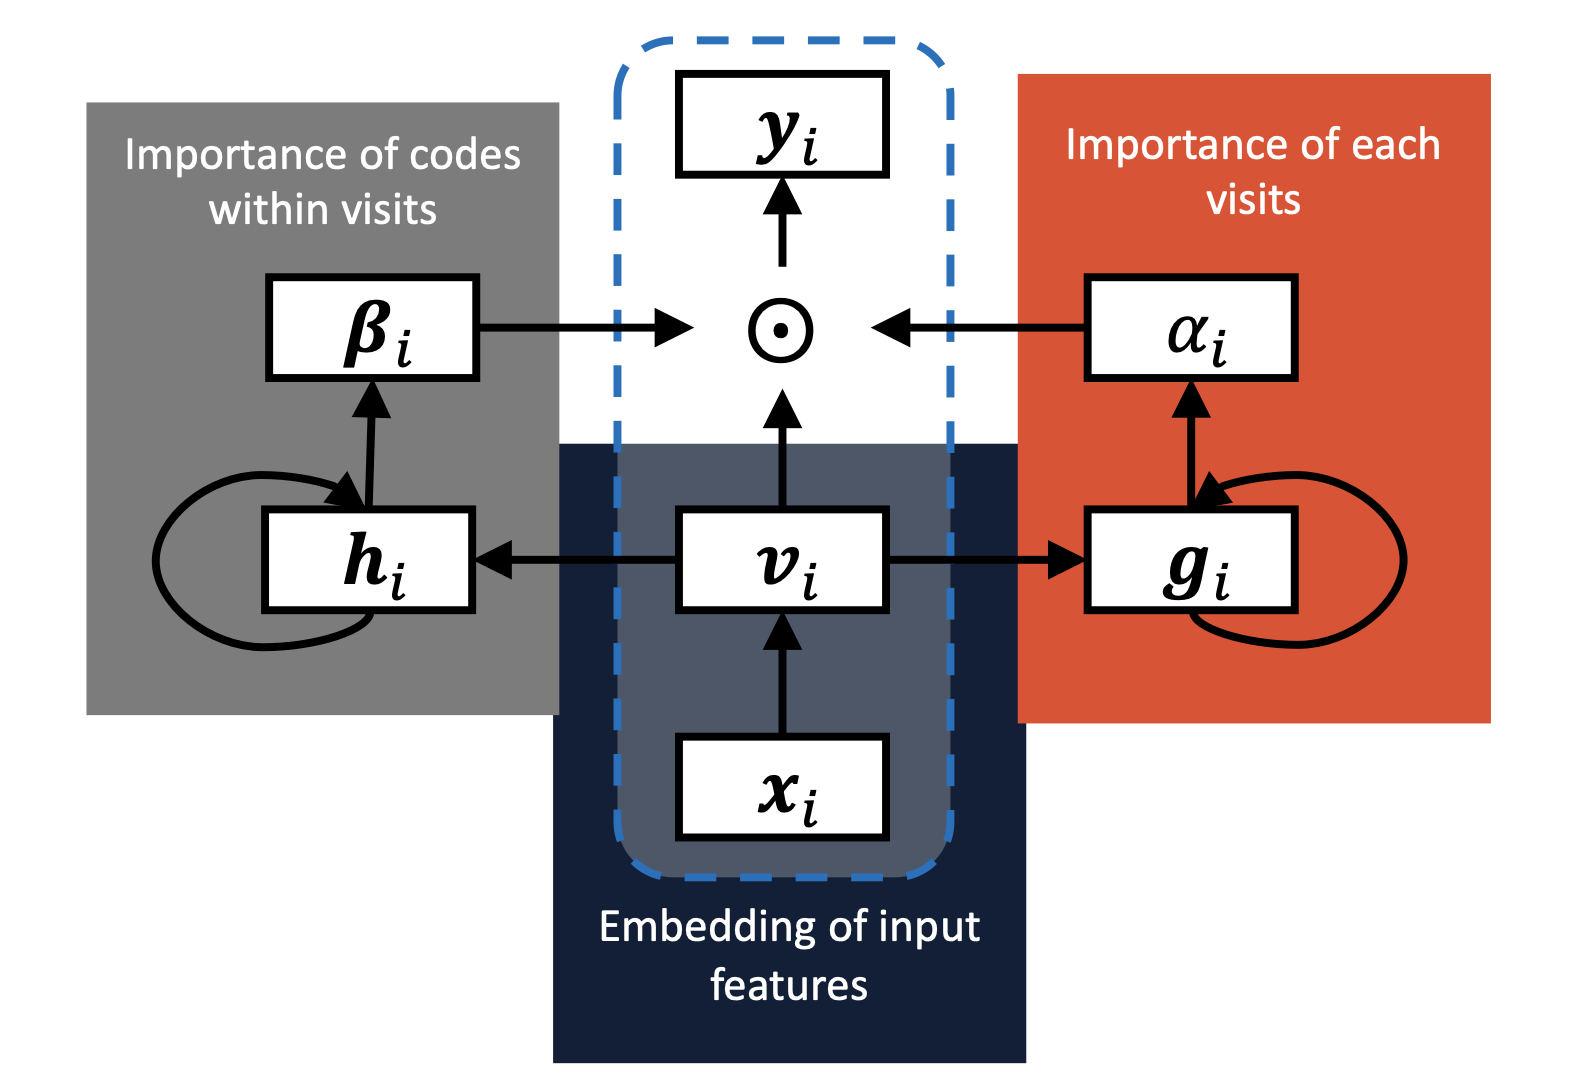

In [15]:
from IPython.display import Image, display
display(Image(filename=image_path))

Unfolded view of RETAIN’s architecture: Given input sequence $\mathbf{x}_1 , . . . , \mathbf{x}_i$, we predict the label $\mathbf{y}_i$.
- Step 1: Embedding,
- Step 2: generating $\alpha$ values using RNN-$\alpha$,
- Step 3: generating $\mathbf{\beta}$ values using RNN-$\beta$,
- Step 4: Generating the context vector using attention and representation vectors,
- Step 5: Making prediction.


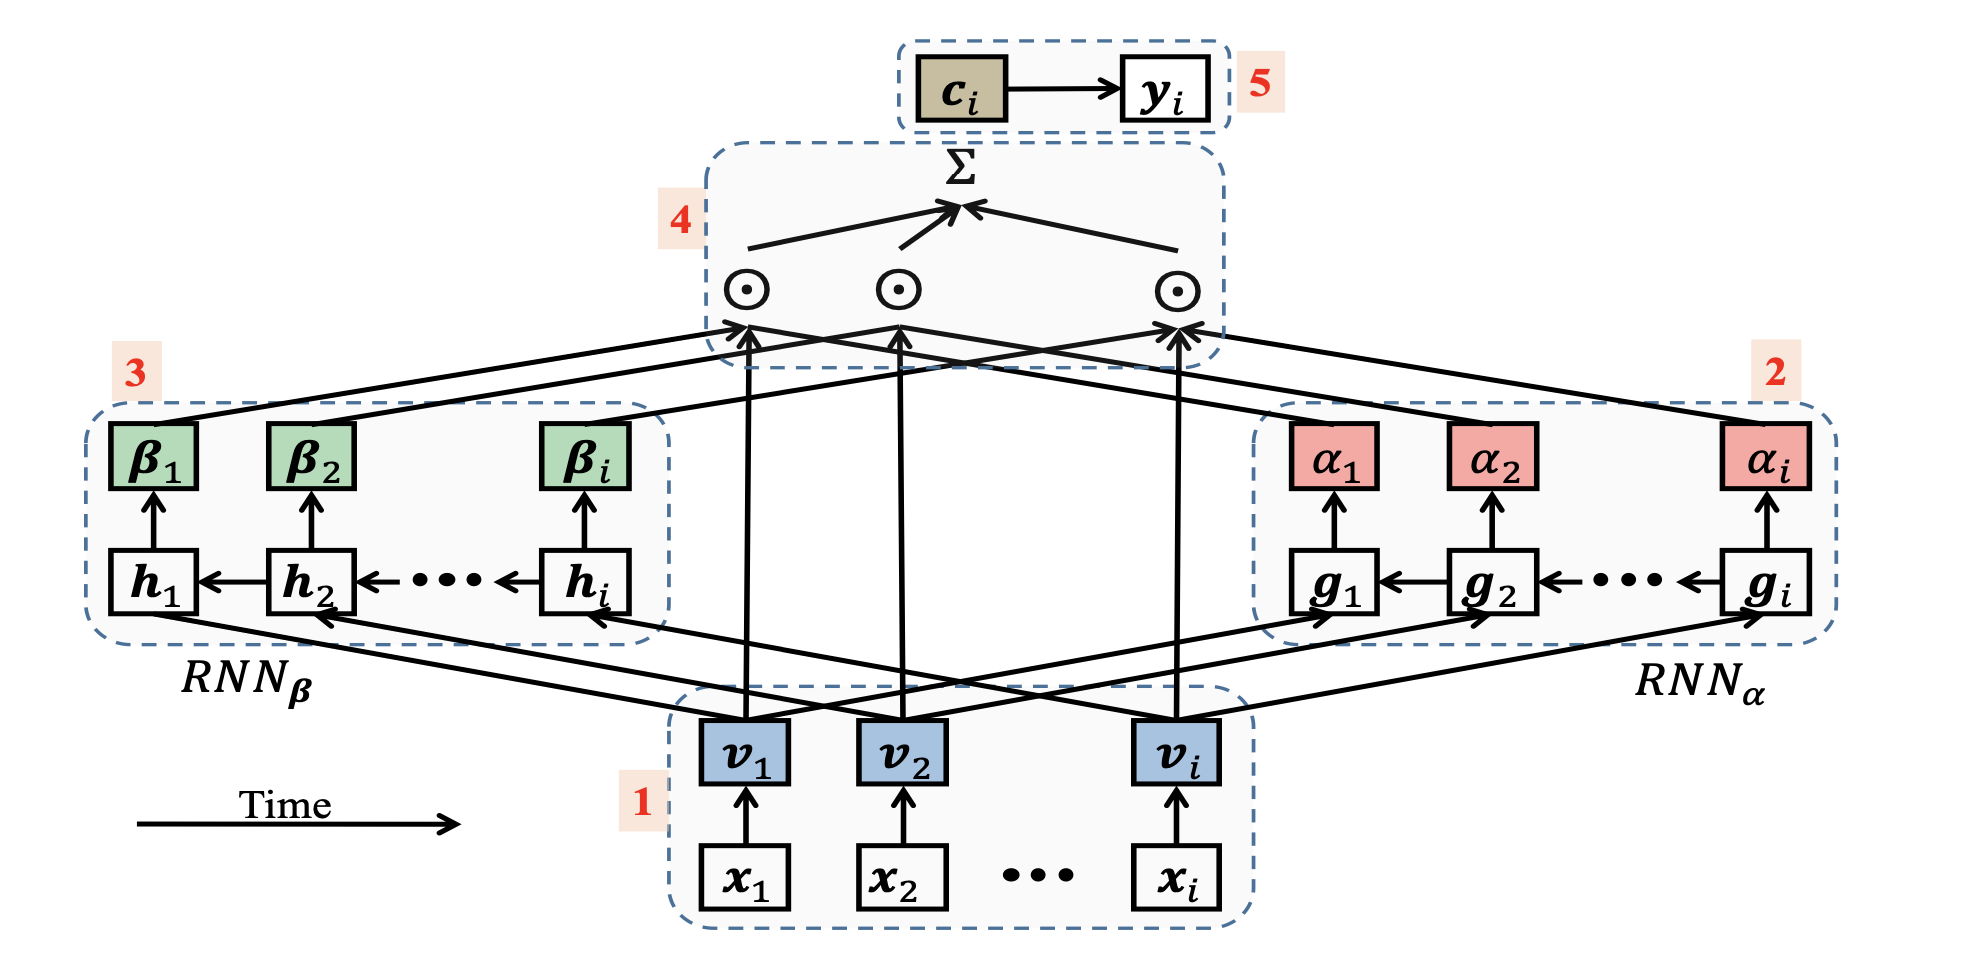

In [16]:
display(Image(filename= "/content/drive/MyDrive/RETAIN-lib/img/retain-2.png"))

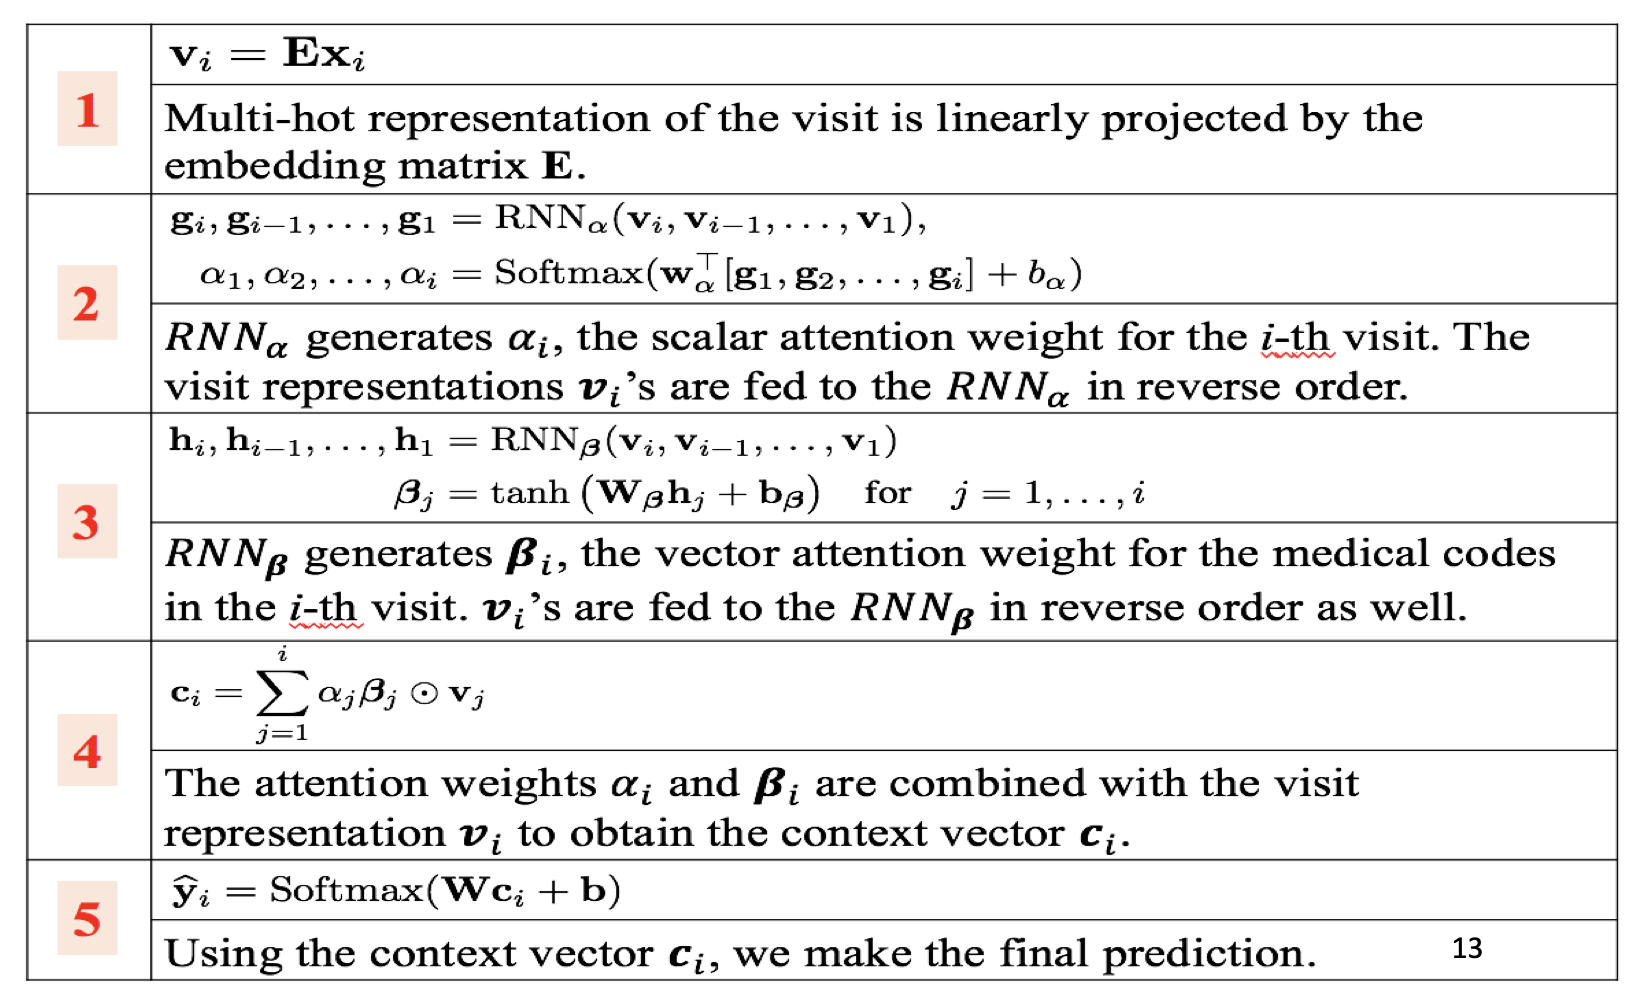

In [17]:
display(Image(filename= "/content/drive/MyDrive/RETAIN-lib/img/retain-3.png"))

### 2.1 Step 2: AlphaAttention

Implement the alpha attention in the second equation of step 2.

In [19]:
class AlphaAttention(torch.nn.Module):

    def __init__(self, embedding_dim):
        super().__init__()
        """
        Define the linear layer `self.a_att` for alpha-attention using `nn.Linear()`;

        Arguments:
            embedding_dim: the embedding dimension
        """

        self.a_att = nn.Linear(embedding_dim, 1)

    def forward(self, g, rev_masks):
        """
        Arguments:
            g: the output tensor from RNN-alpha of shape (batch_size, # visits, embedding_dim)
            rev_masks: the padding masks in reversed time of shape (batch_size, # visits, # diagnosis codes)

        Outputs:
            alpha: the corresponding attention weights of shape (batch_size, # visits, 1)

        Steps:
            1. Calculate the attention score using `self.a_att`
            2. Mask out the padded visits in the attention score with -1e9.
            3. Perform softmax on the attention score to get the attention value.
        """

        attn_score = self.a_att(g) # (batch_size, # visits, 1)
        # Create a mask for actual visits
        mask = rev_masks.sum(dim=2, keepdim=True) != 0
        attn_score = attn_score.masked_fill(mask == 0, -1e9)
        alpha = F.softmax(attn_score, dim=1)

        return alpha


### 2.2 Step 3: BetaAttention

Implement the beta attention in the second equation of step 3.

In [20]:
class BetaAttention(torch.nn.Module):

    def __init__(self, embedding_dim):
        super().__init__()
        """
        Define the linear layer `self.b_att` for beta-attention using `nn.Linear()`;

        Arguments:
            embedding_dim: the embedding dimension
        """
        self.b_att = nn.Linear(embedding_dim, embedding_dim)
    def forward(self, h):
        """
        Arguments:
            h: the output tensor from RNN-beta of shape (batch_size, # visits, embedding_dim)

        Outputs:
            beta: the corresponding attention weights of shape (batch_size, # visitsseq_length, embedding_dim)
        """

        beta = torch.tanh(self.b_att(h))
        return beta

### 2.3 Attention Sum

Implement the sum of attention in step 4.

In [21]:
def attention_sum(alpha, beta, rev_v, rev_masks):
    """
    mask select the hidden states for true visits (not padding visits) and then
        sum the them up.

    Arguments:
        alpha: the alpha attention weights of shape (batch_size, # visits, 1)
        beta: the beta attention weights of shape (batch_size, # visits, embedding_dim)
        rev_v: the visit embeddings in reversed time of shape (batch_size, # visits, embedding_dim)
        rev_masks: the padding masks in reversed time of shape (batch_size, # visits, # diagnosis codes)

    Outputs:
        c: the context vector of shape (batch_size, embedding_dim)
    """
    embedding_dim = rev_v.shape[2]
    # Expand alpha to match the dimensions of beta for broadcasting
    alpha_expanded = alpha.expand(-1, -1, embedding_dim)
    weighted_visits = alpha_expanded * beta * rev_v

    mask = rev_masks.sum(dim=2, keepdim=True) > 0  # Shape: (batch_size, # visits, 1)
    mask_expanded = mask.expand(-1, -1, embedding_dim)

    masked_weighted_visits = weighted_visits * mask_expanded

    c = masked_weighted_visits.sum(dim=1)

    return c

### 2.4 Build RETAIN

In [22]:
def sum_embeddings_with_mask(x, masks):
    """
    Mask select the embeddings for true visits (not padding visits) and then sum the embeddings for each visit up.

    Arguments:
        x: the embeddings of diagnosis sequence of shape (batch_size, # visits, # diagnosis codes, embedding_dim)
        masks: the padding masks of shape (batch_size, # visits, # diagnosis codes)

    Outputs:
        sum_embeddings: the sum of embeddings of shape (batch_size, # visits, embedding_dim)
    """

    x = x * masks.unsqueeze(-1)
    x = torch.sum(x, dim = -2)
    return x

In [23]:
class RETAIN(nn.Module):

    def __init__(self, num_codes, embedding_dim=128):
        super().__init__()
        # Define the embedding layer using `nn.Embedding`. Set `embDimSize` to 128.
        self.embedding = nn.Embedding(num_codes, embedding_dim)
        # Define the RNN-alpha using `nn.GRU()`; Set `hidden_size` to 128. Set `batch_first` to True.
        self.rnn_a = nn.GRU(embedding_dim, embedding_dim, batch_first=True)
        # Define the RNN-beta using `nn.GRU()`; Set `hidden_size` to 128. Set `batch_first` to True.
        self.rnn_b = nn.GRU(embedding_dim, embedding_dim, batch_first=True)
        # Define the alpha-attention using `AlphaAttention()`;
        self.att_a = AlphaAttention(embedding_dim)
        # Define the beta-attention using `BetaAttention()`;
        self.att_b = BetaAttention(embedding_dim)
        # Define the linear layers using `nn.Linear()`;
        self.fc = nn.Linear(embedding_dim, 1)
        # Define the final activation layer using `nn.Sigmoid().
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, masks, rev_x, rev_masks):
        """
        Arguments:
            rev_x: the diagnosis sequence in reversed time of shape (# visits, batch_size, # diagnosis codes)
            rev_masks: the padding masks in reversed time of shape (# visits, batch_size, # diagnosis codes)

        Outputs:
            probs: probabilities of shape (batch_size)
        """
        # 1. Pass the reversed sequence through the embedding layer;
        rev_x = self.embedding(rev_x)
        # 2. Sum the reversed embeddings for each diagnosis code up for a visit of a patient.
        rev_x = sum_embeddings_with_mask(rev_x, rev_masks)
        # 3. Pass the reversed embegginds through the RNN-alpha and RNN-beta layer separately;
        g, _ = self.rnn_a(rev_x)
        h, _ = self.rnn_b(rev_x)
        # 4. Obtain the alpha and beta attentions using `AlphaAttention()` and `BetaAttention()`;
        alpha = self.att_a(g, rev_masks)
        beta = self.att_b(h)
        # 5. Sum the attention up using `attention_sum()`;
        c = attention_sum(alpha, beta, rev_x, rev_masks)
        # 6. Pass the context vector through the linear and activation layers.
        logits = self.fc(c)
        probs = self.sigmoid(logits)
        return probs.squeeze(dim=-1)


# load the model here
retain = RETAIN(num_codes = len(types))
retain

RETAIN(
  (embedding): Embedding(619, 128)
  (rnn_a): GRU(128, 128, batch_first=True)
  (rnn_b): GRU(128, 128, batch_first=True)
  (att_a): AlphaAttention(
    (a_att): Linear(in_features=128, out_features=1, bias=True)
  )
  (att_b): BetaAttention(
    (b_att): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 3 Training and Inferencing

Then, let us implement the `eval()` function first.

In [24]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
def eval(model, val_loader):

    """
    Evaluate the model.

    Arguments:
        model: the RNN model
        val_loader: validation dataloader

    Outputs:
        precision: overall precision score
        recall: overall recall score
        f1: overall f1 score
        roc_auc: overall roc_auc score
    """

    model.eval()
    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()
    model.eval()
    for x, masks, rev_x, rev_masks, y in val_loader:
        y_logit = model(x, masks, rev_x, rev_masks)
        """
        obtain the predicted class (0, 1) by comparing y_logit against 0.5, assign the predicted class to y_hat.
        """
        y_hat = (y_logit > 0.5).int()
        y_score = torch.cat((y_score,  y_logit.detach().to('cpu')), dim=0)
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, y.detach().to('cpu')), dim=0)

    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_score)
    return p, r, f, roc_auc

Now let us implement the `train()` function. Note that `train()` should call `eval()` at the end of each training epoch to see the results on the validation dataset.

In [25]:
def train(model, train_loader, val_loader, n_epochs):
    """
    Train the model.

    Arguments:
        model: the RNN model
        train_loader: training dataloder
        val_loader: validation dataloader
        n_epochs: total number of epochs
    """

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for x, masks, rev_x, rev_masks, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(x, masks, rev_x, rev_masks)
            loss = criterion(y_hat.view(y_hat.shape[0]), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, train_loss))
        p, r, f, roc_auc = eval(model, val_loader)
        print('Epoch: {} \t Validation p: {:.2f}, r:{:.2f}, f: {:.2f}, roc_auc: {:.2f}'.format(epoch+1, p, r, f, roc_auc))
    return round(roc_auc, 2)

In [26]:
# load the model
retain = RETAIN(num_codes = len(types))

# load the loss function
criterion = nn.BCELoss()
# load the optimizer
optimizer = torch.optim.Adam(retain.parameters(), lr=1e-3)

n_epochs = 5
train(retain, train_loader, val_loader, n_epochs)

Epoch: 1 	 Training Loss: 0.636545
Epoch: 1 	 Validation p: 0.75, r:0.79, f: 0.77, roc_auc: 0.82
Epoch: 2 	 Training Loss: 0.402536
Epoch: 2 	 Validation p: 0.76, r:0.71, f: 0.73, roc_auc: 0.81
Epoch: 3 	 Training Loss: 0.258925
Epoch: 3 	 Validation p: 0.78, r:0.77, f: 0.77, roc_auc: 0.82
Epoch: 4 	 Training Loss: 0.148912
Epoch: 4 	 Validation p: 0.78, r:0.80, f: 0.79, roc_auc: 0.83
Epoch: 5 	 Training Loss: 0.079352
Epoch: 5 	 Validation p: 0.80, r:0.80, f: 0.80, roc_auc: 0.84


0.84

## 4 Sensitivity analysis

We will train the same model but with different hyperparameters. We will be using 1 and 0.001 for learning rate, and 4, 128 for embedding dimensions. It shows how model performance varies with different values of learning rate and embedding dimensions.

In [27]:
lr_hyperparameter = [1, 1e-3]
embedding_dim_hyperparameter = [4, 128]
n_epochs = 5
results = {}

for lr in lr_hyperparameter:
    for embedding_dim in embedding_dim_hyperparameter:
        print ('='*50)
        print ({'learning rate': lr, "embedding_dim": embedding_dim})
        print ('-'*50)
        """
            1. Load the model by specifying `embedding_dim` as input to RETAIN. It will create different model with different embedding dimension.
            2. Load the loss function `nn.BCELoss`
            3. Load the optimizer `torch.optim.Adam` with learning rate using `lr` variable
        """
        retain = RETAIN(len(types), embedding_dim)
        loss = nn.BCELoss()
        optimizer = torch.optim.Adam(retain.parameters(), lr)
        roc_auc = train(retain, train_loader, val_loader, n_epochs)
        results['lr:{},emb:{}'.format(str(lr), str(embedding_dim))] =  roc_auc

{'learning rate': 1, 'embedding_dim': 4}
--------------------------------------------------
Epoch: 1 	 Training Loss: 2.405812
Epoch: 1 	 Validation p: 0.56, r:0.52, f: 0.54, roc_auc: 0.54
Epoch: 2 	 Training Loss: 18.981032
Epoch: 2 	 Validation p: 0.54, r:0.63, f: 0.58, roc_auc: 0.52
Epoch: 3 	 Training Loss: 31.560043
Epoch: 3 	 Validation p: 0.53, r:0.91, f: 0.67, roc_auc: 0.52
Epoch: 4 	 Training Loss: 37.911778
Epoch: 4 	 Validation p: 0.54, r:0.89, f: 0.67, roc_auc: 0.55
Epoch: 5 	 Training Loss: 35.634607
Epoch: 5 	 Validation p: 0.58, r:0.89, f: 0.70, roc_auc: 0.61
{'learning rate': 1, 'embedding_dim': 128}
--------------------------------------------------
Epoch: 1 	 Training Loss: 37.251965
Epoch: 1 	 Validation p: 0.55, r:0.95, f: 0.70, roc_auc: 0.57
Epoch: 2 	 Training Loss: 40.025578
Epoch: 2 	 Validation p: 0.54, r:0.95, f: 0.69, roc_auc: 0.55
Epoch: 3 	 Training Loss: 41.654144
Epoch: 3 	 Validation p: 0.54, r:0.96, f: 0.69, roc_auc: 0.54
Epoch: 4 	 Training Loss: 41.71